Enrich镜像 R(Enrich) kernel

Script='/data/work/scripts/Enrich/Enrich.ipynb'
input1='/data/users/yangdong/yangdong_1ac1874280b1481e90852cb6458b67a1/online/output/PlantPhone/Compare/TM0_TM1/RNA_T_0.5/Conservedmarker_Vasculature_TM0_TM1.csv'
input2='/data/users/yangdong/yangdong_1ac1874280b1481e90852cb6458b67a1/online/output/PlantPhone/Compare/TM0_TM1/RNA_T_0.5/marker_Putative rib_splitedseob_TM0_TM1.csv'
1. 其中input1有两个时期的markergene,可以把GO等图左右排列，方便比较.
2. 另外参照[clusterprofiler-comparecluster.html](https://yulab-smu.top/biomedical-knowledge-mining-book/clusterprofiler-comparecluster.html)做一下`cnetplot`在**不同时期**和**不同clsuter**的**占比比较图**

In [33]:
library(AnnotationDbi)
library(stringr) 
library(clusterProfiler)
library(tidyverse)
library(ggnewscale) 
library(tools)
library(ggpubr) 
library(enrichplot) 
library(ggupset) 
library(stats)
library(data.table)
library(lifecycle)
library(dplyr)
library(ggplot2)
library(topGO) 
library(Rgraphviz) 
library(RColorBrewer)
library(wordcloud) 
library(pathview) 
library(UpSetR) 
library(fgsea)
#library(ITAG4.1_241207.OrgDb)

1. 学会用`loadDb()`调用对应的数据库，尤其针对于非模式物种需要的自建库，避免的install和library的问题。但是为了check数据库的GID与筛选到的基因名不存在明显的格式问题，需要检查一下`keys(Tomato, keytype = "GID")`
2. `gmt`文件格式的认识
3. kegg代谢通路的认识，涉及到输入文件的准备、计算和可视化

In [ ]:
# library
Tomato <-loadDb(file="/data/users/lili10/online/script/Enrich/clusterProfiler/ITAG4.1_241207.OrgDb")
kegglist <- read.csv('/data/users/lili10/lili10_642e569efa3b4d56a57481c396194c66/online/input/Clusterprofiler/ITAG4.1_Gene_KEGGID_KEGGNAME_241225.csv')
gmt_go <- "/data/users/lili10/lili10_642e569efa3b4d56a57481c396194c66/online/input/Enrich/ITAG4.1_description_GO_Gene_241220.gmt"
gmt_kegg <- '/data/users/lili10/lili10_642e569efa3b4d56a57481c396194c66/online/input/Enrich/ITAG4.1_KEGGNAME_KEGGID_Gene_241225.gmt'
# Get key information
kegg2gene <- data.frame(kegglist$KEGGID,kegglist$Gene) 
kegg2name <- data.frame(kegglist$KEGGID,kegglist$KEGGNAME)

In [ ]:
# Check the database information
print(Tomato)
class(Tomato)
columns(Tomato)
keys(Tomato, keytype = "GID")

OrgDb object:
| DBSCHEMAVERSION: 2.1
| DBSCHEMA: NOSCHEMA_DB
| ORGANISM: Solanum lycompersicum
| SPECIES: Solanum lycompersicum
| CENTRALID: GID
| Taxonomy ID: 4081
| Db type: OrgDb
| Supporting package: AnnotationDbi



Please see: help('select') for usage information



[1] "Class"       "EVIDENCE"    "EVIDENCEALL" "GENENAME"    "GID"        
 [6] "GO"          "GOALL"       "Goterms"     "KEGGID"      "KEGGNAME"   
[11] "ONTOLOGY"    "ONTOLOGYALL"

In [ ]:
file='/data/users/yangdong/yangdong_1ac1874280b1481e90852cb6458b67a1/online/output/PlantPhone/Compare/TM0_TM1/RNA_T_0.5/Conservedmarker_Vasculature_TM0_TM1.csv'
res <- read.csv(file, row.names = 1)
head(res)
file_prefix <- basename(file)
print(file_prefix)

,TM1_p_val,TM1_avg_log2FC,TM1_pct.1,TM1_pct.2,TM1_p_val_adj,TM0_p_val,TM0_avg_log2FC,TM0_pct.1,TM0_pct.2,TM0_p_val_adj,max_pval,minimump_p_val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-rrn26,1.183961e-237,2.023743,0.756,0.576,3.384588e-233,0.000000e+00,2.3788432,0.712,0.367,0.000000e+00,1.183961e-237,0.000000e+00
gene:Solyc12g056290.2,6.746384e-274,2.751336,0.487,0.187,1.928589e-269,1.329808e-110,3.1164080,0.256,0.073,3.801523e-106,1.329808e-110,1.349277e-273
gene:Solyc00g500164.1,9.578979e-158,1.801340,0.633,0.438,2.738343e-153,8.739389e-84,2.4489730,0.250,0.097,2.498329e-79,8.739389e-84,1.915796e-157
gene:Solyc00g160750.1,1.060475e-152,2.217754,0.418,0.195,3.031581e-148,3.638643e-35,2.1254329,0.108,0.047,1.040179e-30,3.638643e-35,2.120951e-152
gene:Solyc07g007755.2,5.234449e-117,-1.423717,0.424,0.656,1.496372e-112,2.075218e-84,-0.8138965,0.424,0.661,5.932427e-80,2.075218e-84,1.046890e-116
gene:Solyc06g074820.3,1.171698e-103,-1.179514,0.681,0.804,3.349533e-99,3.886129e-89,-0.7733216,0.550,0.763,1.110928e-84,3.886129e-89,2.343396e-103


In [ ]:
# Set the sample name for two groups
sample1='TM0'
sample2='TM1'

# Get DEG1
log2fc=paste0(sample1,'_avg_log2FC')
p_val_adj=paste0(sample1,'_p_val_adj')
deg1 <- rownames_to_column(res, var="Gene")  %>%
    filter(abs(log2fc) > 1 & p_val_adj < 0.05) %>%
    filter(!is.na(Gene) & !duplicated(Gene)) %>%
    { 
        # 判断行数并排序截断
        if(nrow(.) > 3000) {
            arrange(., desc(abs(log2fc))) %>% 
            slice_head(n = 3000)
        } else {
            .
        }
    }
head(deg1)

In [ ]:
# Get DEG2
log2fc=paste0(sample2,'_avg_log2FC')
p_val_adj=paste0(sample2,'_p_val_adj')
deg2 <- rownames_to_column(res, var="Gene")  %>%
    filter(abs(log2fc) > 1 & p_val_adj < 0.05) %>%
    filter(!is.na(Gene) & !duplicated(Gene)) %>%
    { 
        # 判断行数并排序截断
        if(nrow(.) > 3000) {
            arrange(., desc(abs(log2fc))) %>% 
            slice_head(n = 3000)
        } else {
            .
        }
    }
head(deg2)

,Gene,TM1_p_val,TM1_avg_log2FC,TM1_pct.1,TM1_pct.2,TM1_p_val_adj,TM0_p_val,TM0_avg_log2FC,TM0_pct.1,TM0_pct.2,TM0_p_val_adj,max_pval,minimump_p_val,log2fc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MT-rrn26,1.183961e-237,2.023743,0.756,0.576,3.384588e-233,0.000000e+00,2.3788432,0.712,0.367,0.000000e+00,1.183961e-237,0.000000e+00,2.201293
2,gene:Solyc12g056290.2,6.746384e-274,2.751336,0.487,0.187,1.928589e-269,1.329808e-110,3.1164080,0.256,0.073,3.801523e-106,1.329808e-110,1.349277e-273,2.933872
3,gene:Solyc00g500164.1,9.578979e-158,1.801340,0.633,0.438,2.738343e-153,8.739389e-84,2.4489730,0.250,0.097,2.498329e-79,8.739389e-84,1.915796e-157,2.125157
4,gene:Solyc00g160750.1,1.060475e-152,2.217754,0.418,0.195,3.031581e-148,3.638643e-35,2.1254329,0.108,0.047,1.040179e-30,3.638643e-35,2.120951e-152,2.171594
5,gene:Solyc07g007755.2,5.234449e-117,-1.423717,0.424,0.656,1.496372e-112,2.075218e-84,-0.8138965,0.424,0.661,5.932427e-80,2.075218e-84,1.046890e-116,-1.118807
6,gene:Solyc10g048060.2,3.172158e-92,1.919658,0.271,0.109,9.068249e-88,1.311619e-33,1.5973086,0.101,0.048,3.749525e-29,1.311619e-33,6.344316e-92,1.758484


[1] 410

In [ ]:
# Save DEG1 and DEG2
folder_target = '/data/work/output/Enrich/TM0_TM1/'
dir.create(folder_target, recursive = TRUE, showWarnings = FALSE)

file_prefix <- basename(file)
file_target_deg1 <- str_c(folder_target,'deg1', file_prefix)
write.csv(deg, file = file_target_deg1, row.names = FALSE)

file_target_deg1 <- str_c(folder_target,'deg1', file_prefix)
write.csv(deg, file = file_target_deg1, row.names = FALSE)

#### Read the filtered genes list.

In [ ]:
base_theme <- theme(
    plot.title = element_text(size = 16, hjust = 0.5, vjust = 1)
)

res1 <- read.csv(file_target_deg1, row.names = 1)
res1 <- rownames_to_column(res1, var = "Gene") %>% filter(!is.na(Gene) & !duplicated(Gene))
gene1 <- pull(res1, Gene)
geneList1 <- res1$log2fc
names(geneList1) <- gene1    
file_prefix1 <- file_path_sans_ext(basename(file_target_deg1))
head(gene1)

res2 <- read.csv(file_target_deg2, row.names = 1)
res2 <- rownames_to_column(res2, var = "Gene") %>% filter(!is.na(Gene) & !duplicated(Gene))
gene2 <- pull(res2, Gene)
geneList2 <- res2$log2fc
names(geneList2) <- gene2   
file_prefix2 <- file_path_sans_ext(basename(file_target_deg2))
head(gene2)

[1] "MT-rrn26"              "gene:Solyc12g056290.2" "gene:Solyc00g500164.1"
[4] "gene:Solyc00g160750.1" "gene:Solyc07g007755.2" "gene:Solyc10g048060.2"

In [ ]:
ego1 <- enrichGO(
    gene = gene1,
    OrgDb = Tomato,
    keyType = 'GID',
    ont = 'ALL',
    qvalueCutoff = 0.01,
    pvalueCutoff = 0.01
)

ego2 <- enrichGO(
    gene = gene2,
    OrgDb = Tomato,
    keyType = 'GID',
    ont = 'ALL',
    qvalueCutoff = 0.01,
    pvalueCutoff = 0.01
)

Here we find so many scores for marker-genes
- ONTOLOGY: BP/MF/CC
- ID: GO term name
- Description: what is the meaning GO term ID
- GeneRatio: The ratio of the number of genes in the input list that are annotated to the GO term to the total number of genes in the input list
- BgRatio: The ratio of the number of genes in the background list that are annotated to the GO term to the total number of genes in the background list
- RichFactor: The ratio of GeneRatio to BgRatio, indicating the degree of enrichment
- FoldEnrichment: The ratio of the observed gene count to the expected gene count
- zScore: A measure of the statistical significance of the enrichment
- pvalue: The probability that the observed enrichment is due to random chance
- p.adjust: The adjusted p-value for multiple testing correction
- qvalue: The false discovery rate (FDR) adjusted p-value

In [ ]:
ego_df1 <- as.data.frame(ego1)
head(ego_df1)

ego_df2 <- as.data.frame(ego2)
head(ego_df2)

write.csv(ego_df1, str_c(folder_target, file_prefix1, "_df_go.csv"), row.names = FALSE)
write.csv(ego_df2, str_c(folder_target, file_prefix2, "_df_go.csv"), row.names = FALSE)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0009768,BP,GO:0009768,"photosynthesis, light harvesting in photosystem I",11/280,35/25769,0.31428571,28.924388,17.326347,6.781800e-14,1.483858e-10,1.326377e-10,Solyc07g047850.3/Solyc02g070940.1/Solyc02g071030.2/Solyc03g005770.4/Solyc05g056050.3/Solyc10g006230.4/Solyc03g005780.3/Solyc07g063600.3/Solyc02g071010.1/Solyc12g006140.2/Solyc02g070970.1,11
GO:0009765,BP,GO:0009765,"photosynthesis, light harvesting",11/280,57/25769,0.19298246,17.760589,13.277055,2.427684e-11,2.655886e-08,2.374020e-08,Solyc07g047850.3/Solyc02g070940.1/Solyc02g071030.2/Solyc03g005770.4/Solyc05g056050.3/Solyc10g006230.4/Solyc03g005780.3/Solyc07g063600.3/Solyc02g071010.1/Solyc12g006140.2/Solyc02g070970.1,11
GO:0010287,CC,GO:0010287,plastoglobule,14/284,156/24885,0.08974359,7.863624,9.239647,3.453822e-09,7.425718e-07,6.580441e-07,Solyc07g047850.3/Solyc02g070940.1/Solyc02g071030.2/Solyc03g005770.4/Solyc05g056050.3/Solyc10g006230.4/Solyc03g005780.3/Solyc02g069450.3/Solyc02g062340.3/Solyc07g063600.3/Solyc02g071010.1/Solyc04g049380.4/Solyc12g006140.2/Solyc02g070970.1,14
GO:0009522,CC,GO:0009522,photosystem I,11/284,101/24885,0.10891089,9.543125,9.243462,2.257602e-08,2.426922e-06,2.150663e-06,Solyc07g047850.3/Solyc07g066150.1/Solyc02g070940.1/Solyc02g071030.2/Solyc05g056050.3/Solyc03g005780.3/Solyc02g069450.3/Solyc07g063600.3/Solyc02g071010.1/Solyc12g006140.2/Solyc02g070970.1,11
GO:0009523,CC,GO:0009523,photosystem II,10/284,123/24885,0.08130081,7.123841,7.315204,1.544197e-06,1.106674e-04,9.807005e-05,Solyc07g047850.3/Solyc02g070940.1/Solyc02g071030.2/Solyc05g056050.3/Solyc06g084050.4/Solyc03g005780.3/Solyc07g063600.3/Solyc02g071010.1/Solyc12g006140.2/Solyc02g070970.1,10
GO:0009521,CC,GO:0009521,photosystem,12/284,197/24885,0.06091371,5.337456,6.567017,3.014998e-06,1.620562e-04,1.436091e-04,Solyc07g047850.3/Solyc07g066150.1/Solyc02g070940.1/Solyc02g071030.2/Solyc05g056050.3/Solyc06g084050.4/Solyc03g005780.3/Solyc02g069450.3/Solyc07g063600.3/Solyc02g071010.1/Solyc12g006140.2/Solyc02g070970.1,12


## The visualization of GO enrichement
### p1 dotplot()
- 左侧是富集到的GO条目的解释，右侧是条目分到的三个大类
- 圆圈的大小表示富集到相应GO通路的数目，颜色代表可信度，越红代表可信度更高

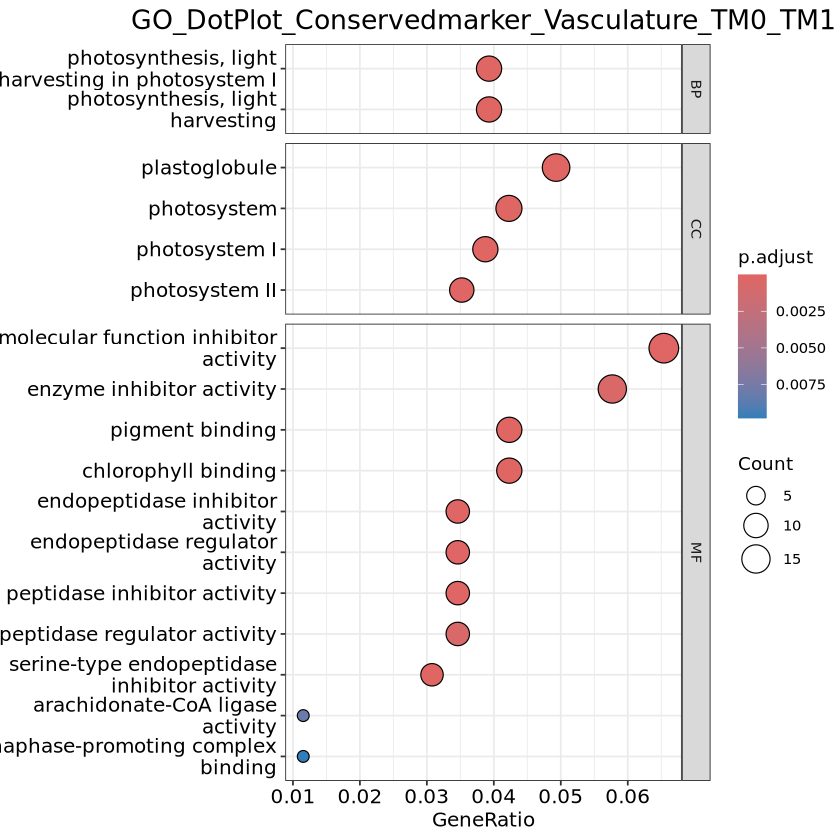

In [ ]:
p1a <- dotplot(ego1, showCategory = 30, split = "ONTOLOGY") +
    facet_grid(ONTOLOGY ~ ., scale = "free", space = "free") +
    scale_colour_gradient(low = "red", high = "blue") +  # 颜色标度仅在此处添加
    labs(title = str_c("GO_DotPlot_", file_prefix1)) +
    base_theme
p1b <- dotplot(ego2, showCategory = 30, split = "ONTOLOGY") +
    facet_grid(ONTOLOGY ~ ., scale = "free", space = "free") +
    scale_colour_gradient(low = "red", high = "blue") +  # 颜色标度仅在此处添加
    labs(title = str_c("GO_DotPlot_", file_prefix2)) +
    base_theme

p1 <- p1a + p1b + plot_layout(ncol = 2)
p1

### p2 cnetplot()
- 显示的是富集到的GO条目之间的关系，一种颜色代表一种GO条目，GO条目圆圈的大小代表基因数目，gray的点代表一种基因
- 通过`showCategory = 5`控制要显示的条目数目，重点突出条目之间，基因间的关系

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


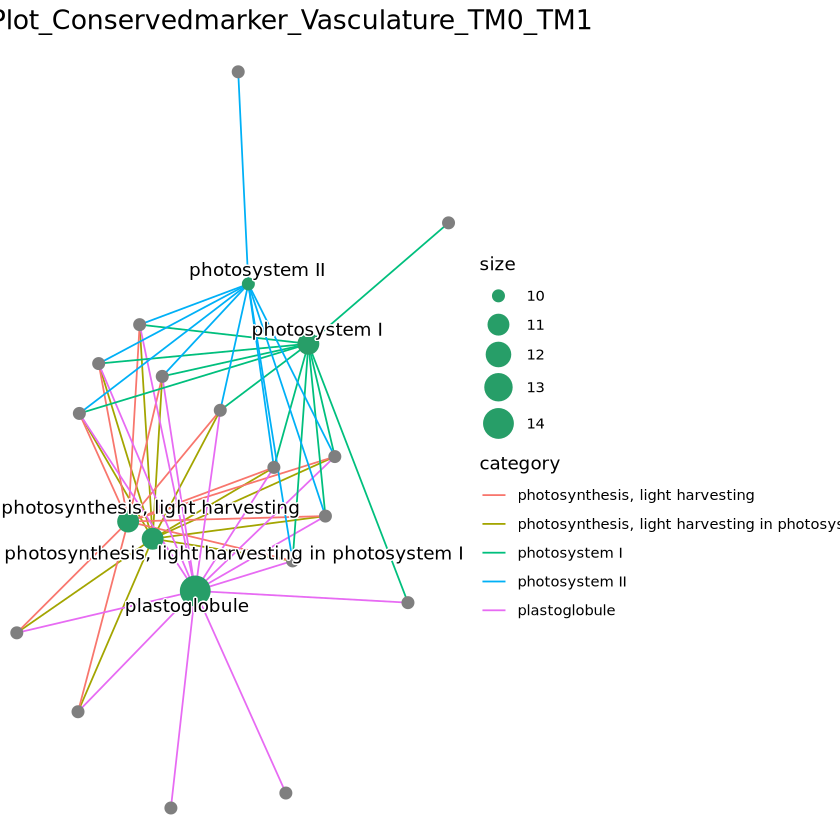

In [ ]:
p2a <- cnetplot(
        ego1,
        foldChange = geneList1,
        showCategory = 5,
        node_label = "category",
        layout = 'kk',
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf
    ) +
    labs(title = str_c("GO_CnetPlot_", file_prefix1)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

p2b <- cnetplot(
        ego2,
        foldChange = geneList2,
        showCategory = 5,
        node_label = "category",
        layout = 'kk',
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf
    ) +
    labs(title = str_c("GO_CnetPlot_", file_prefix2)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

p2 <- p2a + p2b + plot_layout(ncol = 2)
p2

### p3 cnetplot()
- `node_label = "all"`显示基因和GO的名字都显示
- `layout = 'fr'`区别于上面的kk，有什么意义呢

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


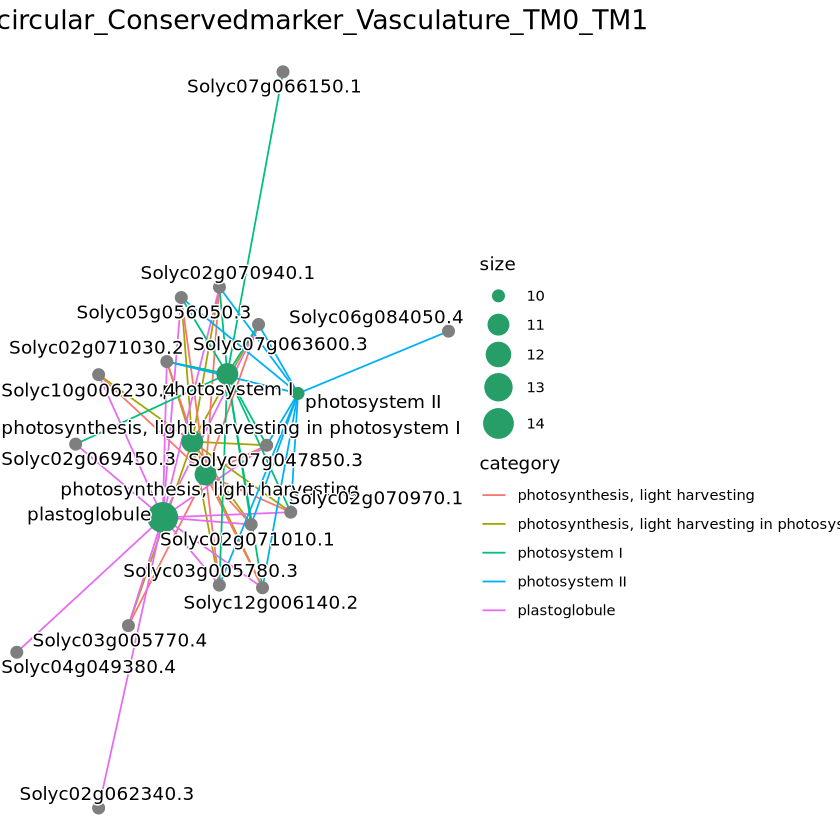

In [ ]:
p3a <- cnetplot(
        ego1,
        foldChange = geneList1,
        showCategory = 5,
        layout = 'fr',
        node_label = "all",
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf, 
        cex_label_gene = 0.4 
    ) +
    labs(title = str_c("GO_CnetPlot_circular_", file_prefix1)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

p3b <- cnetplot(
        ego2,
        foldChange = geneList2,
        showCategory = 5,
        layout = 'fr',
        node_label = "all",
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf, 
        cex_label_gene = 0.4 
    ) +
    labs(title = str_c("GO_CnetPlot_circular_", file_prefix2)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

p3 <- p3a + p3b + plot_layout(ncol = 2)
p3

### p4 upsetplot()
- 用于展示多个集合之间交集关系的可视化工具，通过矩阵和条形图的形式，清晰地展示集合之间的交集、并集和差集关系
- 在 UpSetPlot 中，条形图默认显示的是 交集（Intersection）的大小，而不是并集（Union）的大小

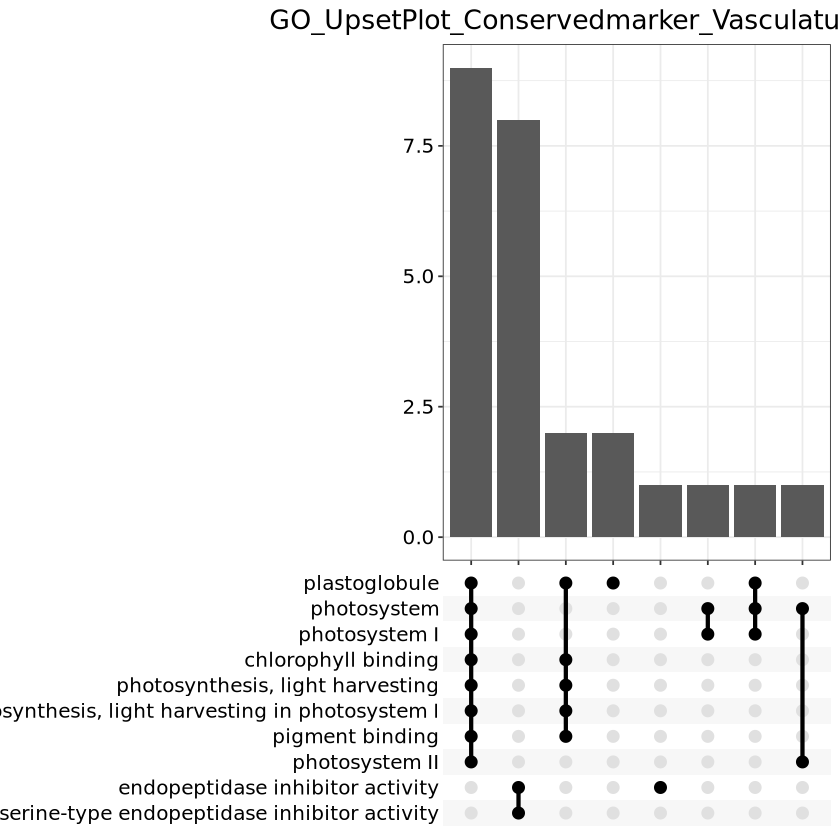

In [ ]:
p4a <- upsetplot(ego1) +
    labs(title = str_c("GO_UpsetPlot_", file_prefix1)) +
    base_theme
p4b <- upsetplot(ego2) +
    labs(title = str_c("GO_UpsetPlot_", file_prefix2)) +
    base_theme

p4 <- p4a + p4b + plot_layout(ncol = 2)
p4

### p5 heatplot()
- `foldChange` 参数用于将基因的表达变化倍数（Fold Change）映射到热图的颜色上
- 

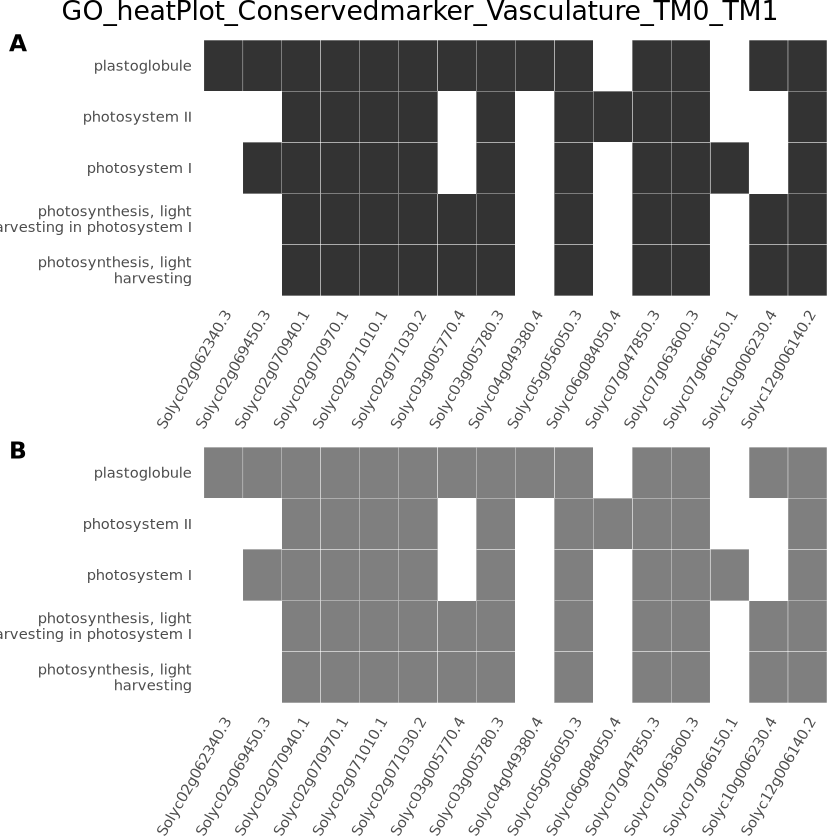

In [ ]:
p5a_1 <- heatplot(ego1, showCategory=5)
p5a_2 <- heatplot(ego1, foldChange=geneList1, showCategory=5)
p5a <- cowplot::plot_grid(p5a_1, p5a_2, ncol=1, labels=LETTERS[1:2]) + ggtitle(str_c("GO_heatPlot_", file_prefix1)) + base_theme

p5b_1 <- heatplot(ego2, showCategory=5)
p5b_2 <- heatplot(ego2, foldChange=geneList2, showCategory=5)
p5b <- cowplot::plot_grid(p5b_1, p5b_2, ncol=1, labels=LETTERS[1:2]) + ggtitle(str_c("GO_heatPlot_", file_prefix2)) + base_theme
p5b

p5 <- p5a + p5b + plot_layout(ncol = 2)
p5

`pairwise_termsim()` 用于计算富集分析结果中各个通路之间的相似性矩阵，并将其添加到富集结果对象的 termsim 属性中

In [ ]:
ego1p <- pairwise_termsim(ego1)
ego2p <- pairwise_termsim(ego2)

### p6 treeplot()
- 一个枝代表一个通路，枝点的圆圈大小代表富集基因的数目，枝点的颜色代表可信度即p.adjust
- 树关系依据于`pairwise_termsim()`的计算，枝之间越近代表相似性越高

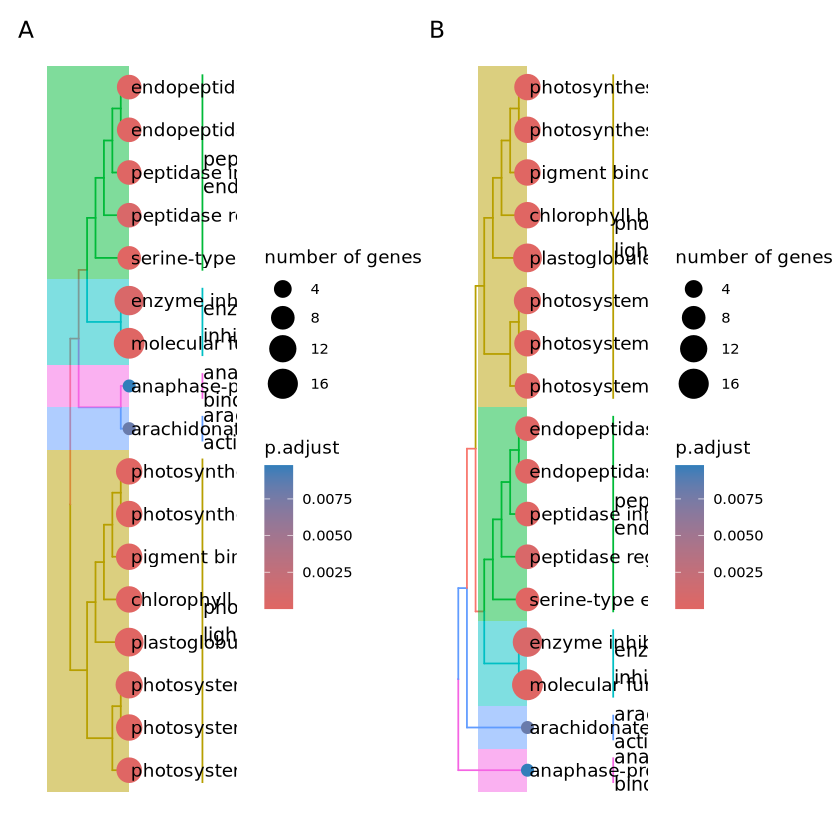

In [ ]:
p6a_1 <- treeplot(ego1p)
p6a_2 <- treeplot(ego1p, cluster.params = list(method = "average"))
p6a <- aplot::plot_list(p6a_1, p6a_2, tag_levels='A')

p6b_1 <- treeplot(ego2p)
p6b_2 <- treeplot(ego2p, cluster.params = list(method = "average"))
p6b <- aplot::plot_list(p6b_1, p6b_2, tag_levels='A')

p6 <- p6a + p6b + plot_layout(ncol = 2)
p6

In [ ]:
### p7 emapplot()
- 绘制富集分析的通路相似性图
- 圆圈大小，圆圈颜色，连线代表通路关系，聚集的通路在一起


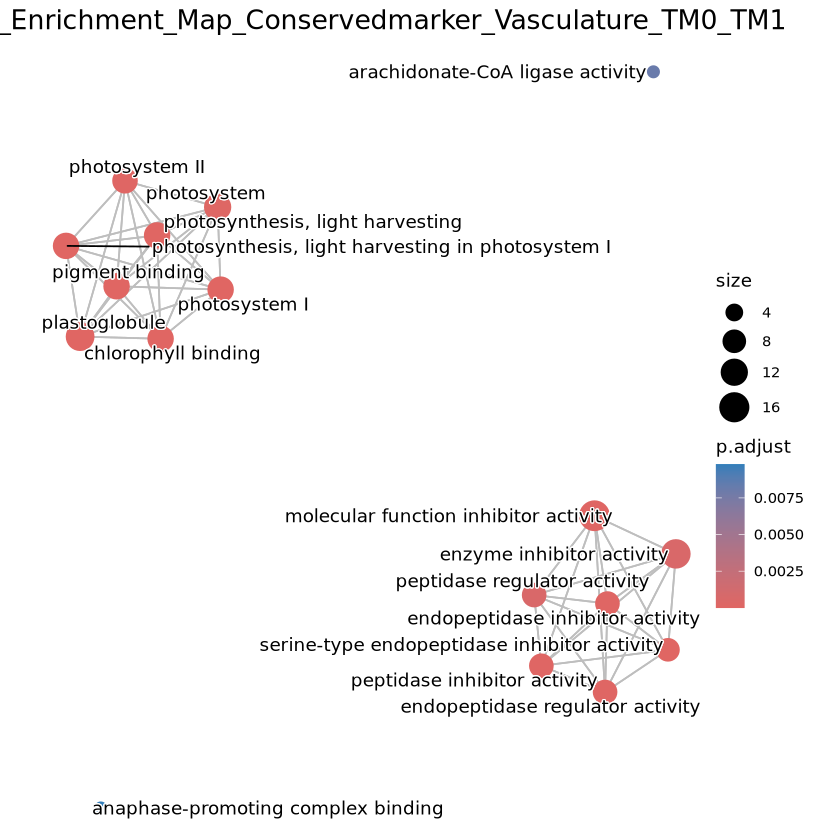

In [ ]:
p7a <- emapplot(ego1p, layout = 'fr') + ggtitle(str_c("GO_Enrichment_Map_", file_prefix1)) + base_theme
p7b <- emapplot(ego2p, layout = 'fr') + ggtitle(str_c("GO_Enrichment_Map_", file_prefix2)) + base_theme

p7 <- p7a + p7b + plot_layout(ncol = 2)
p7

In [ ]:
ego1_BP <- enrichGO(
    gene = gene1,
    OrgDb = Tomato,
    keyType = 'GID',
    ont = 'BP',
    qvalueCutoff = 0.05,
    pvalueCutoff = 0.05
)

ego2_BP <- enrichGO(
    gene = gene2,
    OrgDb = Tomato,
    keyType = 'GID',
    ont = 'BP',
    qvalueCutoff = 0.05,
    pvalueCutoff = 0.05
)

### p8 goplot()
- 可视化 GO 富集分析结果,生成一个气泡图，展示富集分析中显著的 GO 术语
- 展示相互关系relationship: `isa`,`negatively regulate`,`part of`,`regulates`

Warning message:
"ggrepel: 52 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


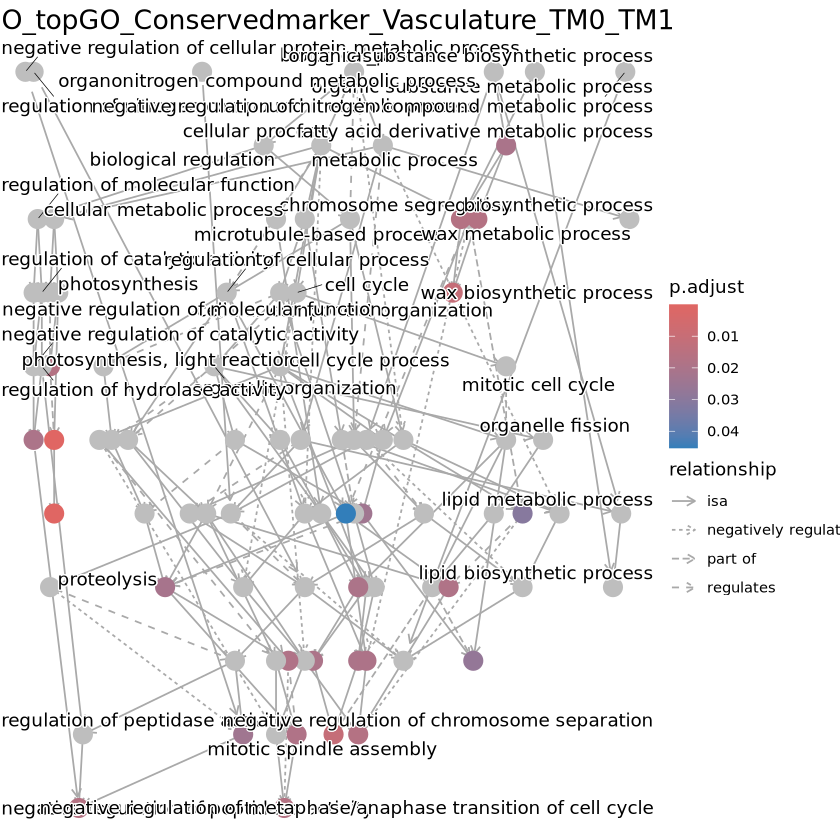

In [ ]:
p8a <- goplot(ego1_BP, showCategory = 10) + ggtitle(str_c("GO_topGO_", file_prefix1)) + base_theme 
p8b <- goplot(ego2_BP, showCategory = 10) + ggtitle(str_c("GO_topGO_", file_prefix2)) + base_theme 

p8 <- p8a + p8b + plot_layout(ncol = 2)
p8

## KEGG analysis

In [ ]:
kk1 <- enricher(gene1,TERM2GENE = kegg2gene,TERM2NAME = kegg2name,pvalueCutoff = 0.05,qvalueCutoff = 0.05)
kk_df1 <- as.data.frame(kk1)
write.csv(kk_df1, str_c(folder_target, file_prefix1, "_df_kegg.csv"), row.names = FALSE)

kk2 <- enricher(gene2,TERM2GENE = kegg2gene,TERM2NAME = kegg2name,pvalueCutoff = 0.05,qvalueCutoff = 0.05)
kk_df2 <- as.data.frame(kk2)
write.csv(kk_df2, str_c(folder_target, file_prefix2, "_df_kegg.csv"), row.names = FALSE)

In [ ]:
### p9 dotplot()
- 富集到该KEGG通路的基因占总输入基因的多少，count和p.adjust

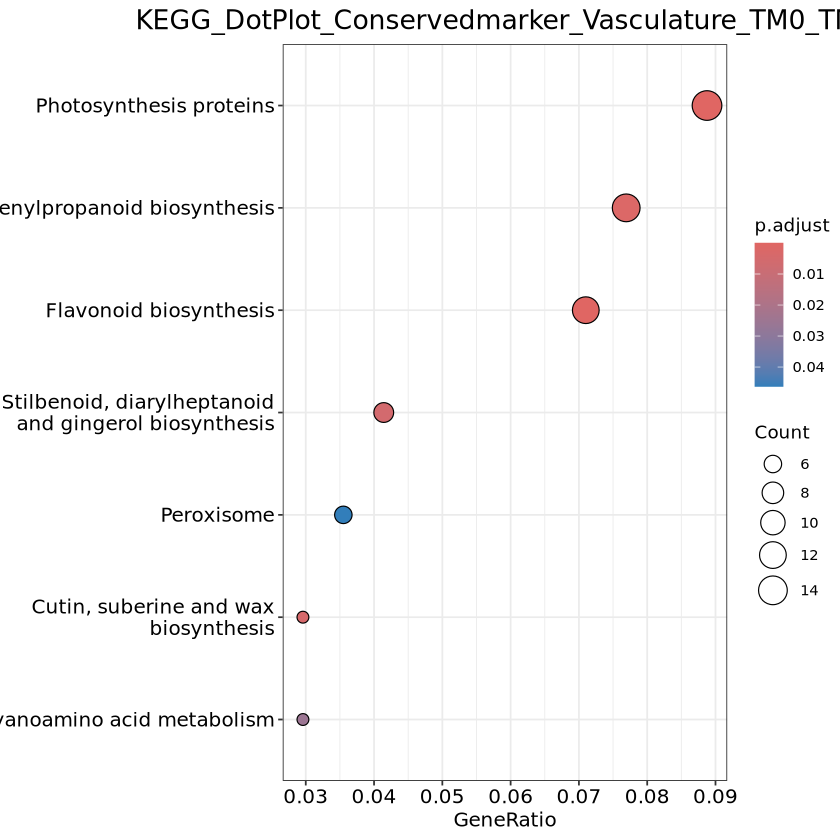

In [ ]:
p9a <- dotplot(kk1,showCategory = 30) +
    labs(title = str_c("KEGG_DotPlot_", file_prefix1)) + 
    base_theme

p9b <- dotplot(kk2,showCategory = 30) +
    labs(title = str_c("KEGG_DotPlot_", file_prefix2)) + 
    base_theme

p9 <- p9a + p9b + plot_layout(ncol = 2)
p9

### p10 cnetplot()
- 面向KEGG的通路关系图

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


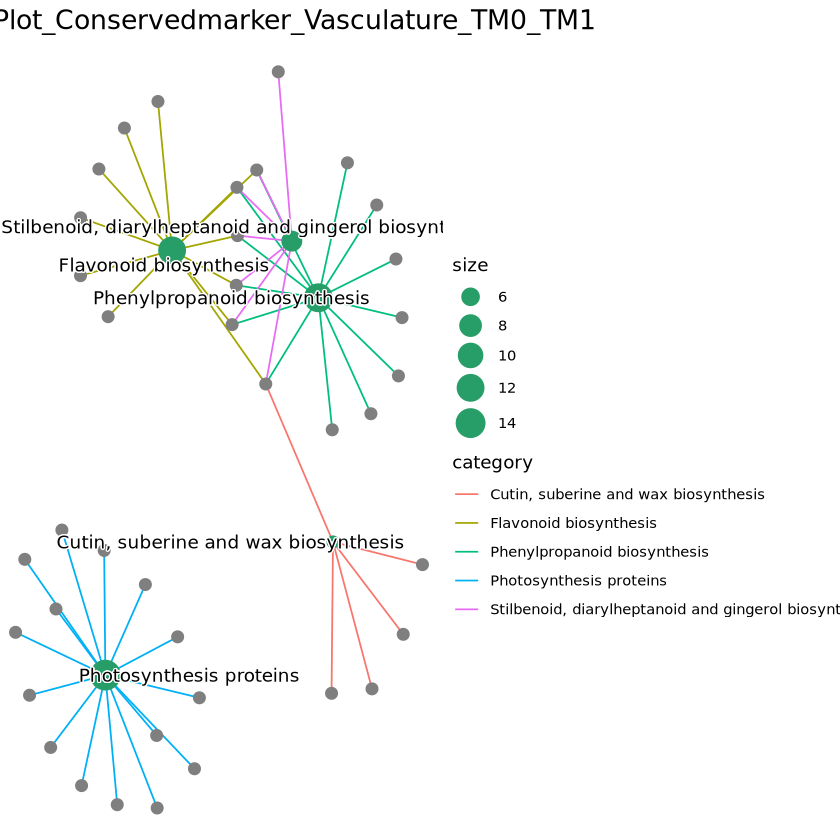

In [ ]:
p10a <- cnetplot(
        kk1,
        foldChange = geneList1,
        showCategory = 5,
        node_label = "category",
        layout = 'kk',
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf
    ) +
    labs(title = str_c("KEGG_CnetPlot_", file_prefix1)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')
p10b <- cnetplot(
        kk2,
        foldChange = geneList2,
        showCategory = 5,
        node_label = "category",
        layout = 'kk',
        color_edge = "category",
        color_category = "#279e68",
        max.overlaps = Inf
    ) +
    labs(title = str_c("KEGG_CnetPlot_", file_prefix2)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

p10 <- p10a + p10b + plot_layout(ncol = 2)
p10

### p11 cnetplot()
- 面向KEGG的通路关系图，多一些注释

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


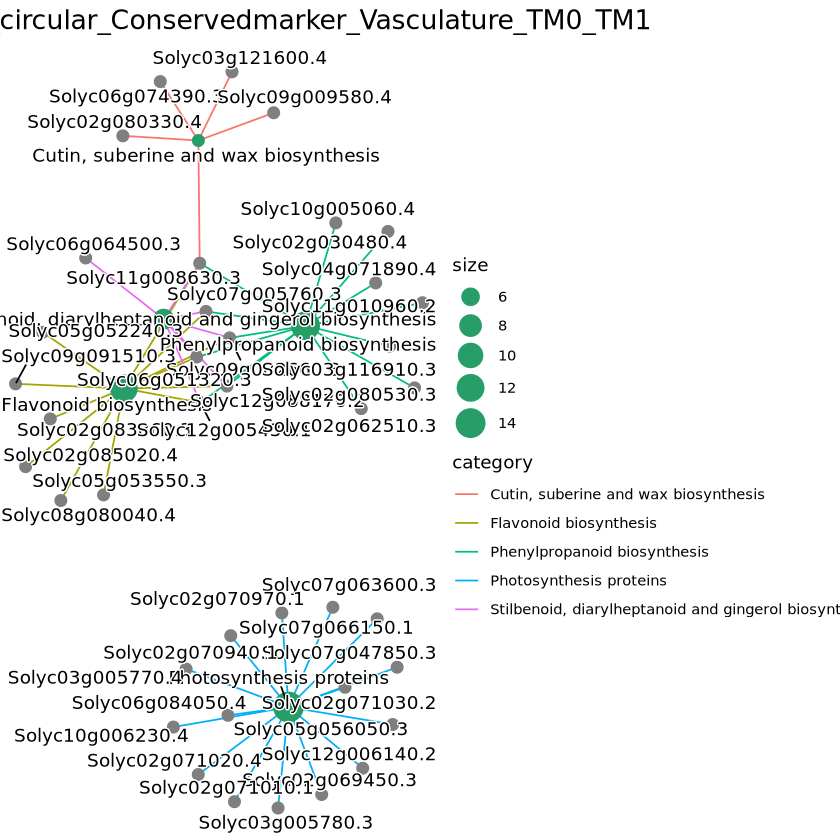

In [ ]:
p11a <- cnetplot(
        kk1,
        foldChange = geneList1,
        showCategory = 5,
        node_label = "all",
        layout = 'fr',
        color_category = "#279e68",
        color_edge = "category",
        max.overlaps = Inf,
        cex_label_gene = 0.6  
    ) +
    labs(title = str_c("KEGG_CnetPlot_circular_", file_prefix1)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')
p11b <- cnetplot(
        kk2,
        foldChange = geneList2,
        showCategory = 5,
        node_label = "all",
        layout = 'fr',
        color_category = "#279e68",
        color_edge = "category",
        max.overlaps = Inf,
        cex_label_gene = 0.6  
    ) +
    labs(title = str_c("KEGG_CnetPlot_circular_", file_prefix2)) +
    base_theme + 
    scale_color_gradient2(low='darkblue', mid = "#ff7f0e", high='darkred')

p11 <- p11a + p11b + plot_layout(ncol = 2)
p11

# p12 upsetplot(kk)

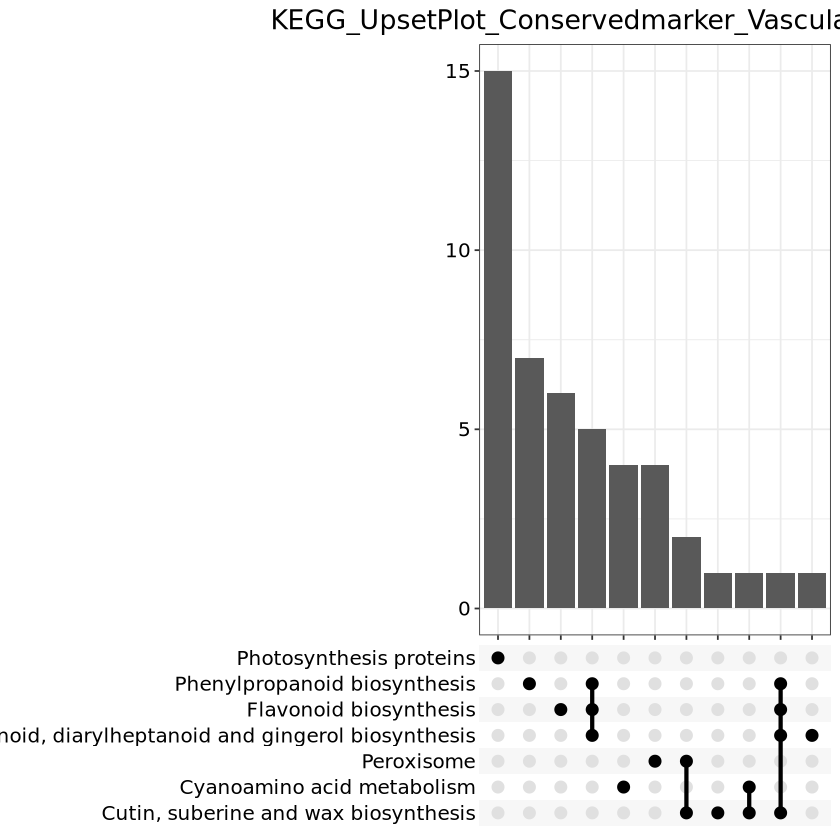

In [ ]:
p12a <- upsetplot(kk1) +
    labs(title = str_c("KEGG_UpsetPlot_", file_prefix1)) +
    base_theme
p12b <- upsetplot(kk2) +
    labs(title = str_c("KEGG_UpsetPlot_", file_prefix2)) +
    base_theme

p12 <- p12a + p12b + plot_layout(ncol = 2)
p12

### p13 heatplot(kk)

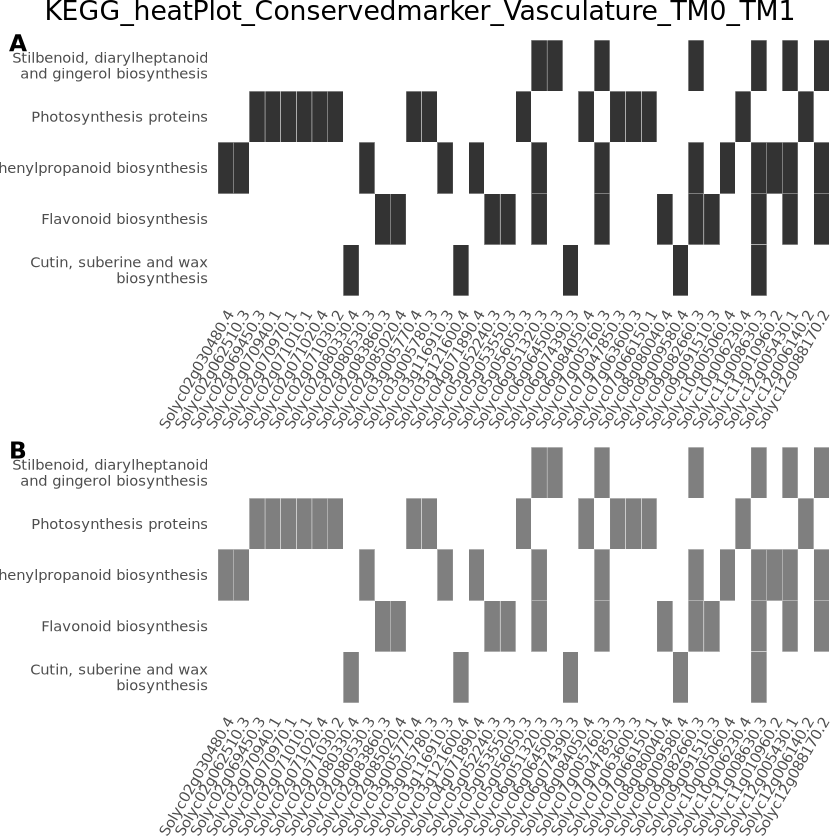

In [ ]:
p13a_1 <- heatplot(kk1, showCategory=5)
p13a_2 <- heatplot(kk1, foldChange=geneList1, showCategory=5)
p13a <- cowplot::plot_grid(p13a_1, p13a_2, ncol=1, labels=LETTERS[1:2]) + ggtitle(str_c("KEGG_heatPlot_", file_prefix1)) + base_theme

p13b_1 <- heatplot(kk2, showCategory=5)
p13b_2 <- heatplot(kk2, foldChange=geneList2, showCategory=5)
p13b <- cowplot::plot_grid(p13b_1, p13b_2, ncol=1, labels=LETTERS[1:2]) + ggtitle(str_c("KEGG_heatPlot_", file_prefix2)) + base_theme

p13 <- p13a + p13b + plot_layout(ncol = 2)
p13

### p14 treeplot(kk2)

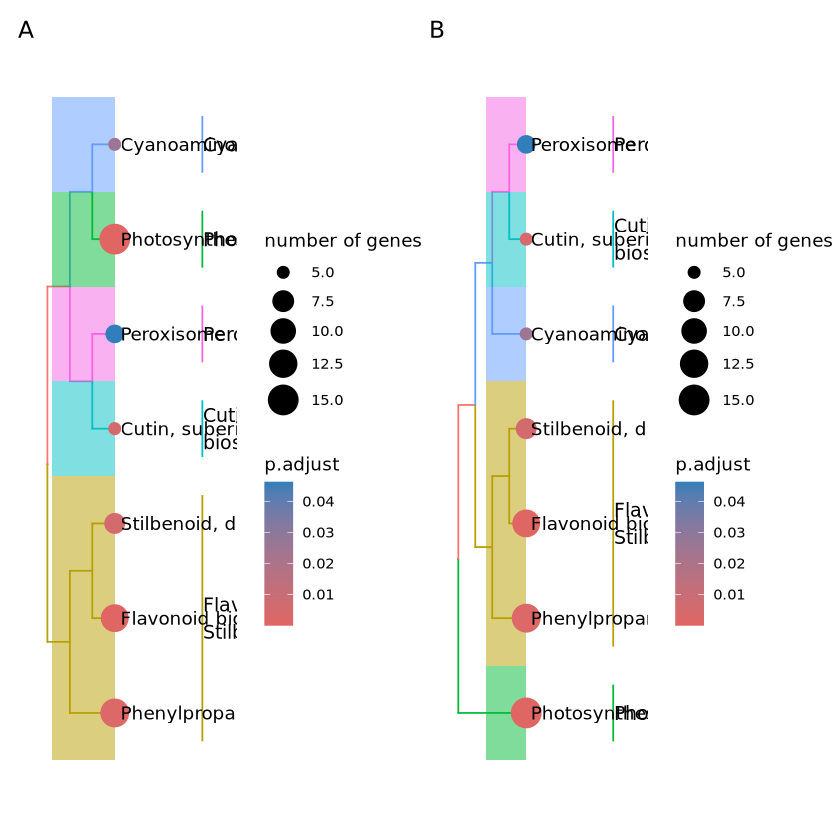

In [ ]:
kk1p <- pairwise_termsim(kk1)
kk2p <- pairwise_termsim(kk2)

p14a_1 <- treeplot(kk1p)
p14a_2 <- treeplot(kk1p, cluster.params = list(method = "average"))
p14a <- aplot::plot_list(p14a_1, p14a_2, tag_levels='A')

p14b_1 <- treeplot(kk2p)
p14b_2 <- treeplot(kk2p, cluster.params = list(method = "average"))
p14b <- aplot::plot_list(p14b_1, p14b_2, tag_levels='A')

p14 <- p14a + p14b + plot_layout(ncol = 2)
p14

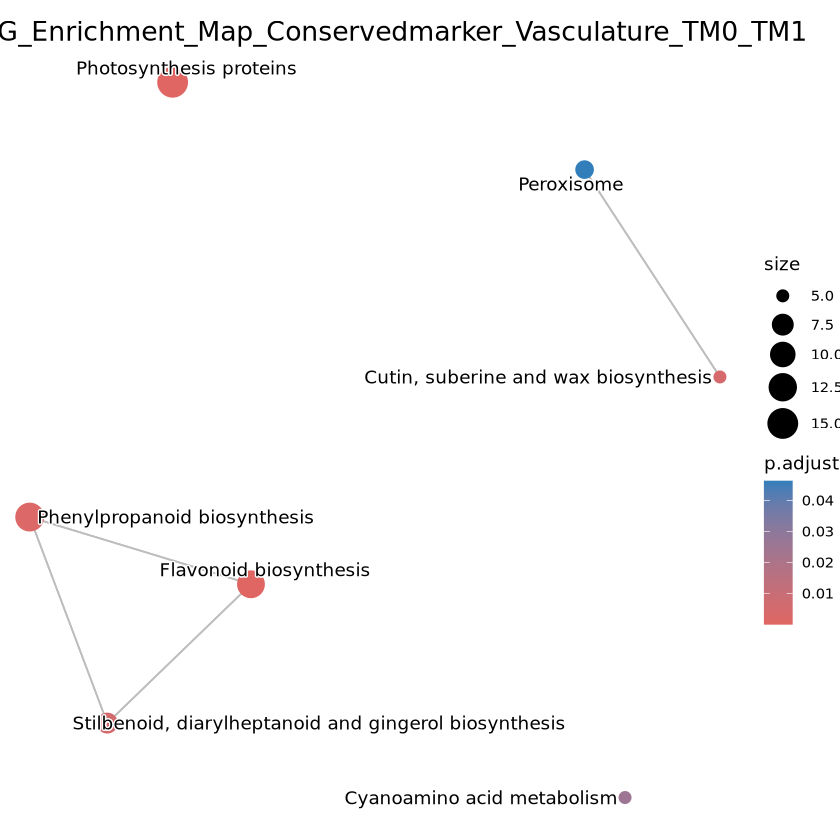

In [ ]:
p15a <- emapplot(kk1p, layout = 'fr') + ggtitle(str_c("KEGG_Enrichment_Map_", file_prefix1)) + base_theme
p15b <- emapplot(kk2p, layout = 'fr') + ggtitle(str_c("KEGG_Enrichment_Map_", file_prefix2)) + base_theme

p15 <- p15a + p15b + plot_layout(ncol = 2)
p15

In [39]:
pdf(str_c(folder_target, file_prefix, "_GO_dotplot.pdf"), height = 30, width = 8)
print(p1)
dev.off()

pdf(str_c(folder_target, file_prefix, "_KEGG_dotplot.pdf"), height = 10, width = 8)
print(p9)
dev.off()

pdf(str_c(folder_target, file_prefix, "_cnet.pdf"), height = 15, width = 18)
print(p2)
print(p3)
print(p4)
print(p7)
print(p10)
print(p11)
print(p12)
print(p15)
dev.off() 
    
pdf(str_c(folder_target, file_prefix, "_heatplot.pdf"), height = 15, width = 30)
print(p5)
print(p6)
print(p8)
wordcloud(words = ego_BP$Description, freq = ego_BP$Count, scale=(c(3, .1)), colors=brewer.pal(8, "Dark2"), max.words = 25)
print(p13)
print(p14)
wordcloud(words = kk$Description, freq = kk$Count, scale=(c(3, .1)), colors=brewer.pal(8, "Dark2"), max.words = 25)
dev.off() 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [ ]:
dir = '/data/work/output/FGSEA/'
file1 = file_target_deg1
file2 = file_target_deg2

dir.create(dir, recursive = TRUE, showWarnings = FALSE)

pathwayLines_go <- strsplit(readLines(gmt_go), "\t")
TomatoGOPathways <- lapply(pathwayLines_go, tail, -2)
names(TomatoGOPathways) <- sapply(pathwayLines_go, head, 1)

pathwayLines_kegg <- strsplit(readLines(gmt_kegg), "\t")
TomatoKEGGPathways <- lapply(pathwayLines_kegg, tail, -2)
names(TomatoKEGGPathways) <- sapply(pathwayLines_kegg, head, 1)

In [ ]:
data1 <- read.csv(file1, row.names = 1) 
deg1 <- rownames_to_column(data1, var = "Gene") %>%
    filter(!is.na(Gene) & !duplicated(Gene))
head(deg1)
TomatoGORanks1 <- deg1$log2fc 
names(TomatoGORanks1) <- deg1$Gene 
TomatoGORanks1 <- sort(TomatoGORanks1, decreasing = F) 

data2 <- read.csv(file2, row.names = 1) 
deg2 <- rownames_to_column(data2, var = "Gene") %>%
    filter(!is.na(Gene) & !duplicated(Gene))
head(deg2)
TomatoGORanks2 <- deg2$log2fc 
names(TomatoGORanks2) <- deg2$Gene 
TomatoGORanks2 <- sort(TomatoGORanks2, decreasing = F)

,Gene,TM1_p_val,TM1_avg_log2FC,TM1_pct.1,TM1_pct.2,TM1_p_val_adj,TM0_p_val,TM0_avg_log2FC,TM0_pct.1,TM0_pct.2,TM0_p_val_adj,max_pval,minimump_p_val,log2fc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MT-rrn26,1.183961e-237,2.023743,0.756,0.576,3.384588e-233,0.000000e+00,2.3788432,0.712,0.367,0.000000e+00,1.183961e-237,0.000000e+00,2.201293
2,gene:Solyc12g056290.2,6.746384e-274,2.751336,0.487,0.187,1.928589e-269,1.329808e-110,3.1164080,0.256,0.073,3.801523e-106,1.329808e-110,1.349277e-273,2.933872
3,gene:Solyc00g500164.1,9.578979e-158,1.801340,0.633,0.438,2.738343e-153,8.739389e-84,2.4489730,0.250,0.097,2.498329e-79,8.739389e-84,1.915796e-157,2.125157
4,gene:Solyc00g160750.1,1.060475e-152,2.217754,0.418,0.195,3.031581e-148,3.638643e-35,2.1254329,0.108,0.047,1.040179e-30,3.638643e-35,2.120951e-152,2.171594
5,gene:Solyc07g007755.2,5.234449e-117,-1.423717,0.424,0.656,1.496372e-112,2.075218e-84,-0.8138965,0.424,0.661,5.932427e-80,2.075218e-84,1.046890e-116,-1.118807
6,gene:Solyc10g048060.2,3.172158e-92,1.919658,0.271,0.109,9.068249e-88,1.311619e-33,1.5973086,0.101,0.048,3.749525e-29,1.311619e-33,6.344316e-92,1.758484


[1] "MT-rrn26"              "gene:Solyc12g056290.2" "gene:Solyc00g500164.1"
[4] "gene:Solyc00g160750.1" "gene:Solyc07g007755.2" "gene:Solyc10g048060.2"

,Gene,TM1_p_val,TM1_avg_log2FC,TM1_pct.1,TM1_pct.2,TM1_p_val_adj,TM0_p_val,TM0_avg_log2FC,TM0_pct.1,TM0_pct.2,TM0_p_val_adj,max_pval,minimump_p_val,log2fc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MT-rrn26,1.183961e-237,2.023743,0.756,0.576,3.384588e-233,0.000000e+00,2.3788432,0.712,0.367,0.000000e+00,1.183961e-237,0.000000e+00,2.201293
2,Solyc12g056290.2,6.746384e-274,2.751336,0.487,0.187,1.928589e-269,1.329808e-110,3.1164080,0.256,0.073,3.801523e-106,1.329808e-110,1.349277e-273,2.933872
3,Solyc00g500164.1,9.578979e-158,1.801340,0.633,0.438,2.738343e-153,8.739389e-84,2.4489730,0.250,0.097,2.498329e-79,8.739389e-84,1.915796e-157,2.125157
4,Solyc00g160750.1,1.060475e-152,2.217754,0.418,0.195,3.031581e-148,3.638643e-35,2.1254329,0.108,0.047,1.040179e-30,3.638643e-35,2.120951e-152,2.171594
5,Solyc07g007755.2,5.234449e-117,-1.423717,0.424,0.656,1.496372e-112,2.075218e-84,-0.8138965,0.424,0.661,5.932427e-80,2.075218e-84,1.046890e-116,-1.118807
6,Solyc10g048060.2,3.172158e-92,1.919658,0.271,0.109,9.068249e-88,1.311619e-33,1.5973086,0.101,0.048,3.749525e-29,1.311619e-33,6.344316e-92,1.758484


In [ ]:
fgseaRes1 <- fgsea(pathways = TomatoGOPathways, 
                  stats = TomatoGORanks1,
                  eps = 0.0,
                  minSize = 15,
                  maxSize = 500)
head(fgseaRes1)

fgseaRes2 <- fgsea(pathways = TomatoGOPathways, 
                  stats = TomatoGORanks2,
                  eps = 0.0,
                  minSize = 15,
                  maxSize = 500)
head(fgseaRes2)

### p1 plotEnrichment()
- 横轴的竖线应该代表富集到的通路，拐点对应一个竖线，富集分数代表什么呢？

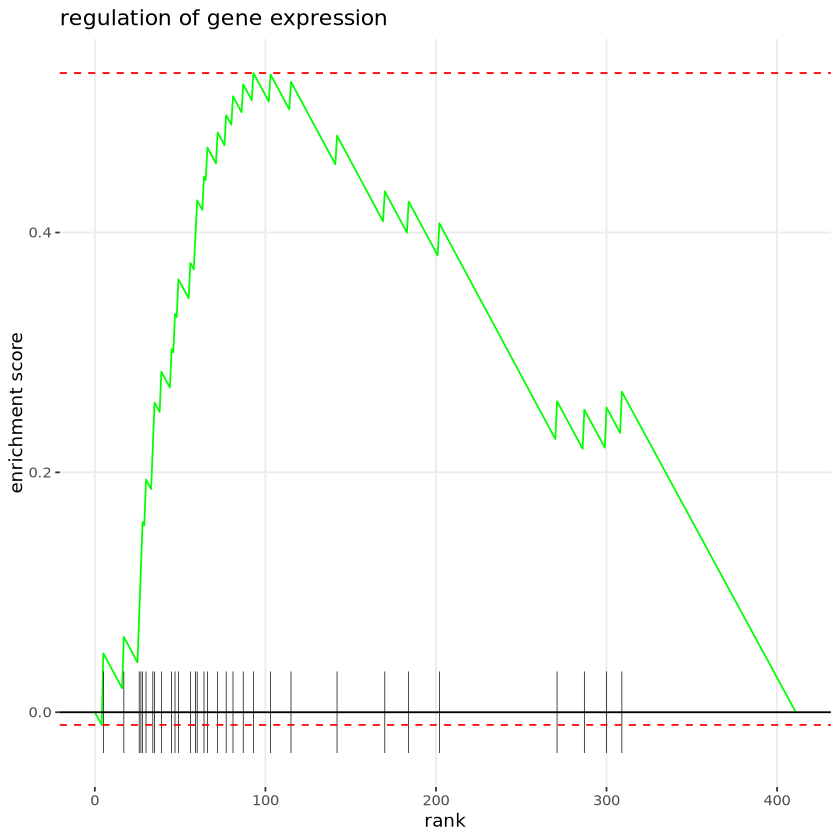

In [ ]:
p1a <- plotEnrichment(TomatoGOPathways[[head(fgseaRes1[order(pval), ], 1)$pathway]],
                         TomatoGORanks1) + labs(title = head(fgseaRes1[order(pval), ], 1)$pathway)
p1b <- plotEnrichment(TomatoGOPathways[[head(fgseaRes2[order(pval), ], 1)$pathway]],
                         TomatoGORanks2) + labs(title = head(fgseaRes2[order(pval), ], 1)$pathway)

p1 <- p1a + p1b + plot_layout(ncol = 2)
p1


### p2 plotGseaTable()
- 通路，基因条目上下调，NES，padj

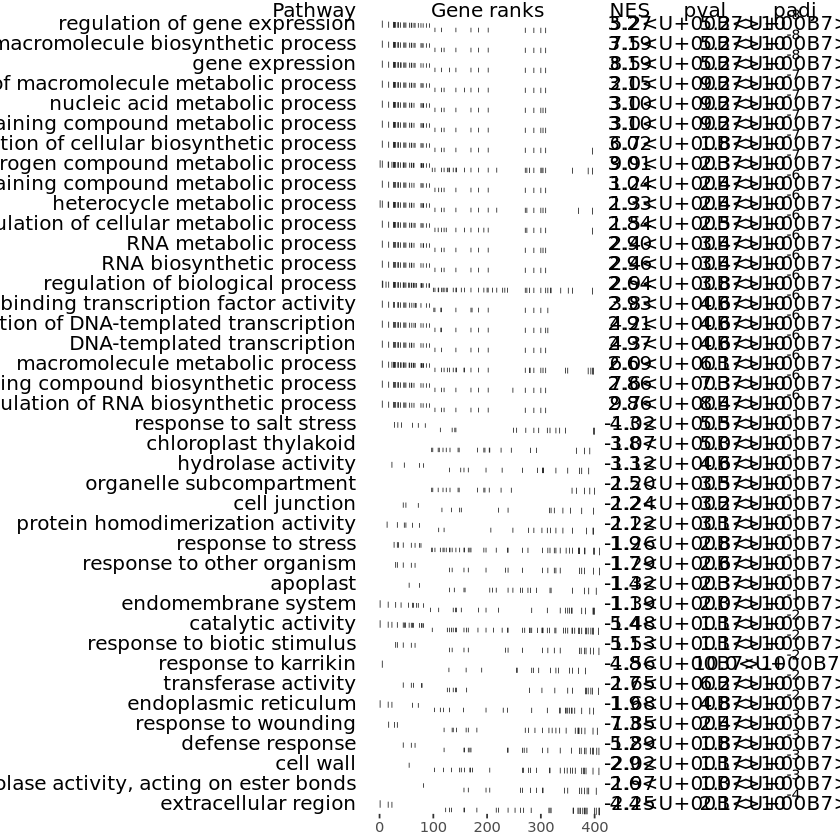

In [ ]:
topPathwaysUp1 <- fgseaRes1[ES > 0][head(order(pval), n = 20), pathway]
topPathwaysDown1 <- fgseaRes1[ES < 0][head(order(pval), n = 20), pathway]
topPathways1 <- c(topPathwaysUp, rev(topPathwaysDown))
p2a <- plotGseaTable(TomatoGOPathways[topPathways1], TomatoGORanks1, fgseaRes1, gseaParam = 0.5)

topPathwaysUp2 <- fgseaRes2[ES > 0][head(order(pval), n = 20), pathway]
topPathwaysDown2 <- fgseaRes2[ES < 0][head(order(pval), n = 20), pathway]
topPathways2 <- c(topPathwaysUp, rev(topPathwaysDown))
p2b <- plotGseaTable(TomatoGOPathways[topPathways2], TomatoGORanks2, fgseaRes2, gseaParam = 0.5)

p2 <- p2a + p2b + plot_layout(ncol = 2)
p2

### p3 更严格的padj

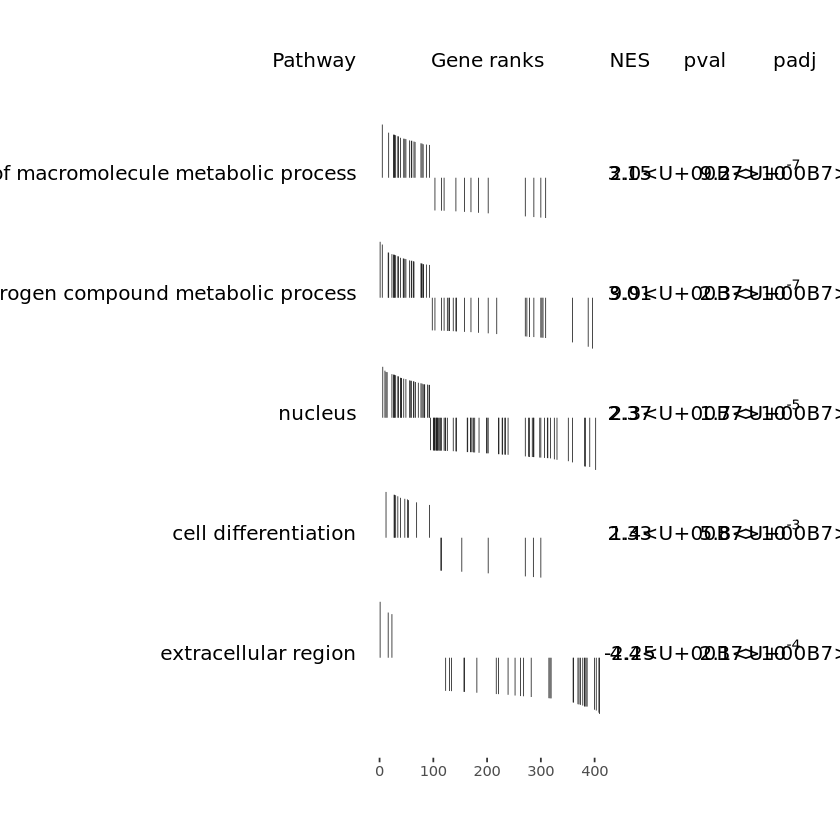

In [ ]:
collapsedPathways1 <- collapsePathways(fgseaRes[order(pval)][padj < 0.01], TomatoGOPathways, TomatoGORanks1)

mainPathways1 <- fgseaRes1[pathway %in% collapsedPathways1$mainPathways][order(-NES), pathway]

p3a <- plotGseaTable(TomatoGOPathways[mainPathways1], TomatoGORanks1, fgseaRes1, gseaParam = 0.5)

collapsedPathways2 <- collapsePathways(fgseaRes[order(pval)][padj < 0.01], TomatoGOPathways, TomatoGORanks2)

mainPathways2 <- fgseaRes2[pathway %in% collapsedPathways2$mainPathways][order(-NES), pathway]

p3b <- plotGseaTable(TomatoGOPathways[mainPathways2], TomatoGORanks2, fgseaRes2, gseaParam = 0.5)

p3 <- p3a + p3b + plot_layout(ncol = 2)

p3

In [ ]:
TomatoKEGGRanks1 <- deg1$log2fc 
names(TomatoKEGGRanks1) <- deg1$Gene 
TomatoKEGGRanks1 <- sort(TomatoKEGGRanks1, decreasing = F) 

fgseaRes_kegg1 <- fgsea(pathways = TomatoKEGGPathways, 
                       stats = TomatoKEGGRanks1,
                       eps = 0.0,
                       minSize = 15,
                       maxSize = 500)

TomatoKEGGRanks2 <- deg2$log2fc 
names(TomatoKEGGRanks2) <- deg2$Gene 
TomatoKEGGRanks2 <- sort(TomatoKEGGRanks2, decreasing = F) 

fgseaRes_kegg2 <- fgsea(pathways = TomatoKEGGPathways, 
                       stats = TomatoKEGGRanks2,
                       eps = 0.0,
                       minSize = 15,
                       maxSize = 500)

### p4

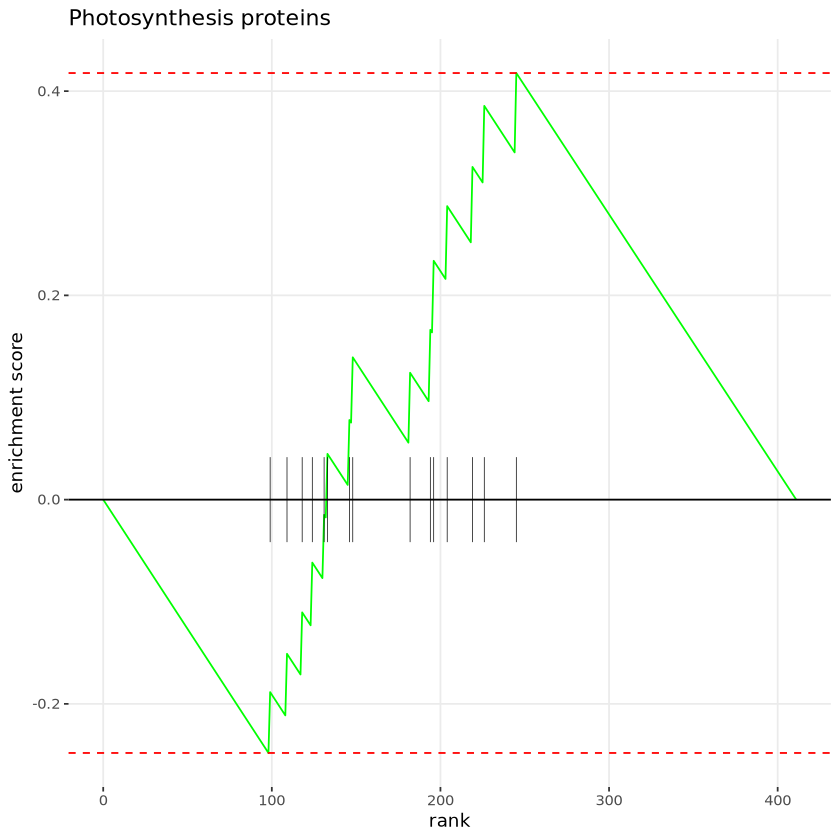

In [ ]:
p4a <- plotEnrichment(TomatoKEGGPathways[[head(fgseaRes_kegg1[order(pval), ], 1)$pathway]],
                         TomatoKEGGRanks1) + labs(title = head(fgseaRes_kegg1[order(pval), ], 1)$pathway)

p4b <- plotEnrichment(TomatoKEGGPathways[[head(fgseaRes_kegg2[order(pval), ], 1)$pathway]],
                         TomatoKEGGRanks2) + labs(title = head(fgseaRes_kegg2[order(pval), ], 1)$pathway)

p4 <- p4a + p4b + plot_layout(ncol = 2)
p4

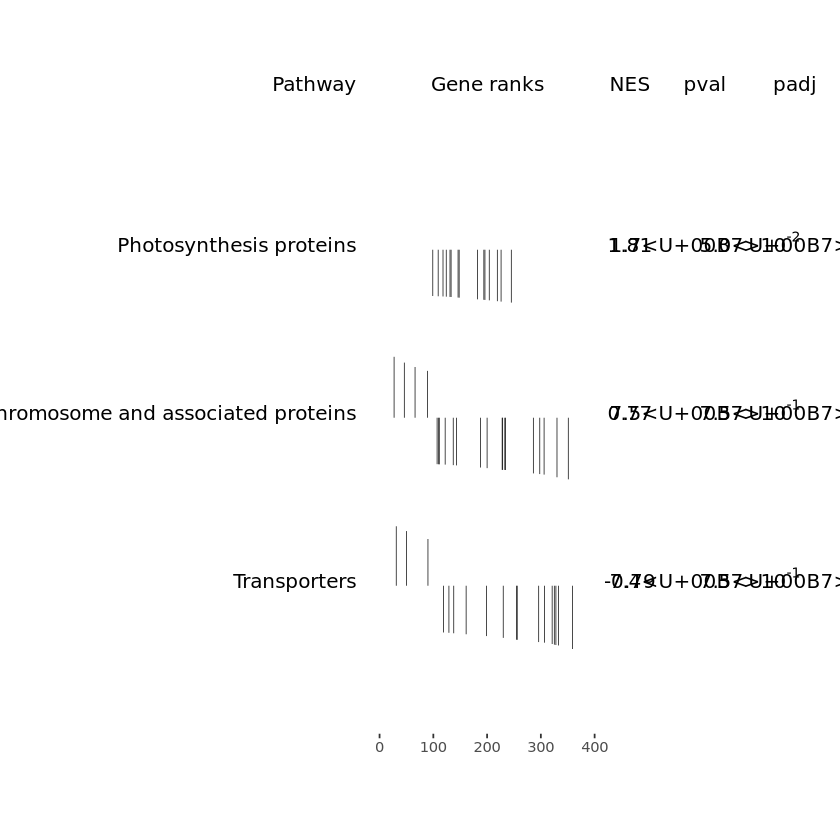

In [ ]:
topPathwaysUp_kegg1 <- fgseaRes_kegg1[ES > 0][head(order(pval), n = 20), pathway]
topPathwaysDown_kegg1 <- fgseaRes_kegg1[ES < 0][head(order(pval), n = 20), pathway]
topPathways_kegg1 <- c(topPathwaysUp_kegg1, rev(topPathwaysDown_kegg1))
p5a <- plotGseaTable(TomatoKEGGPathways[topPathways_kegg1], TomatoKEGGRanks1, fgseaRes_kegg1, gseaParam = 0.5)

topPathwaysUp_kegg2 <- fgseaRes_kegg2[ES > 0][head(order(pval), n = 20), pathway]
topPathwaysDown_kegg2 <- fgseaRes_kegg2[ES < 0][head(order(pval), n = 20), pathway]
topPathways_kegg2 <- c(topPathwaysUp_kegg2, rev(topPathwaysDown_kegg2))
p5b <- plotGseaTable(TomatoKEGGPathways[topPathways_kegg2], TomatoKEGGRanks2, fgseaRes_kegg2, gseaParam = 0.5)

p5 <- p5a + p5b + plot_layout(ncol = 2)
p5


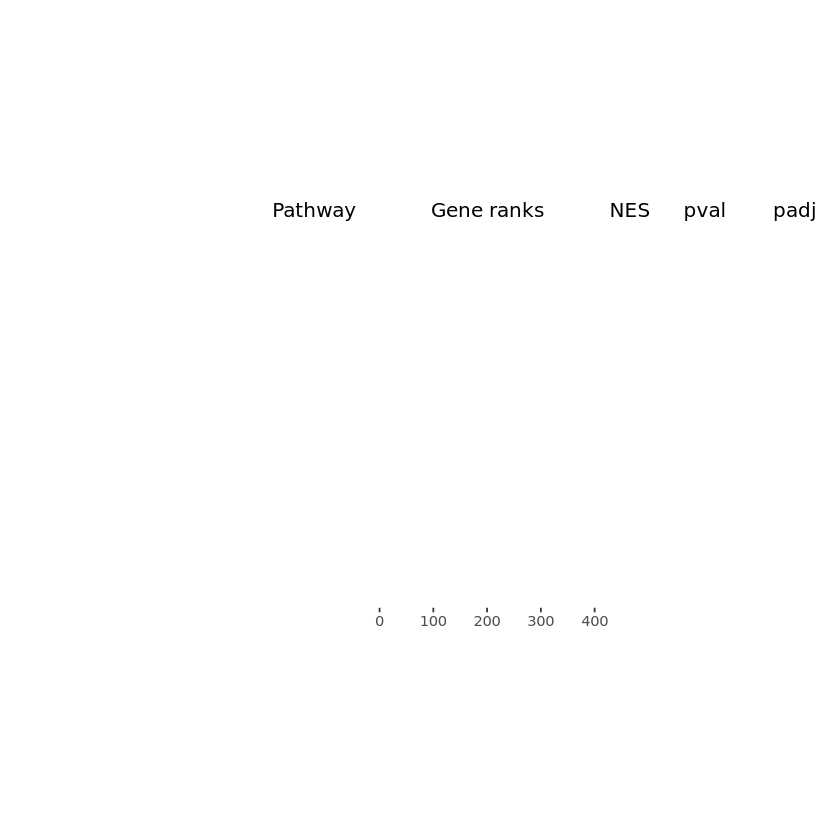

In [ ]:
collapsedPathways_kegg1 <- collapsePathways(fgseaRes_kegg1[order(pval)][padj < 0.01], TomatoKEGGPathways1, TomatoKEGGRanks1)

mainPathways_kegg1 <- fgseaRes_kegg1[pathway %in% collapsedPathways_kegg1$mainPathways][order(-NES), pathway]

p6 <- plotGseaTable(TomatoKEGGPathways1[mainPathways_kegg1], TomatoKEGGRanks, fgseaRes_kegg, gseaParam = 0.5)

p6

In [ ]:
pdf(str_c(dir, file_path_sans_ext(basename(file)), "_lof2fc.pdf"), height = 15, width = 15)
print(p1)
print(p2)
print(p3)
print(p4)
print(p5)
print(p6)
dev.off()

In [ ]:
Toppathway <- fgseaRes[order(pval),][1,]$pathway
leadingEdgegenes <- fgseaRes[order(pval),][1,]$leadingEdge
leadingEdgegenes_df <- data.frame(leadingEdgegenes)
names(leadingEdgegenes_df) <- Toppathway

write.csv(leadingEdgegenes_df,file = str_c(dir, file_path_sans_ext(basename(file)), "_go_leadingEdgegenes.csv"),row.names = FALSE)

In [59]:
Toppathway_kegg <- fgseaRes_kegg[order(pval),][1,]$pathway
leadingEdgegenes_kegg <- fgseaRes_kegg[order(pval),][1,]$leadingEdge
leadingEdgegenes_df_kegg <- data.frame(leadingEdgegenes_kegg)
names(leadingEdgegenes_df_kegg) <- Toppathway_kegg

write.csv(leadingEdgegenes_df_kegg,file = str_c(dir, file_path_sans_ext(basename(file)), "_kegg_leadingEdgegenes.csv"),row.names = FALSE)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (4.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"There were 40 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)"
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (4.87% of the list).
The order of t

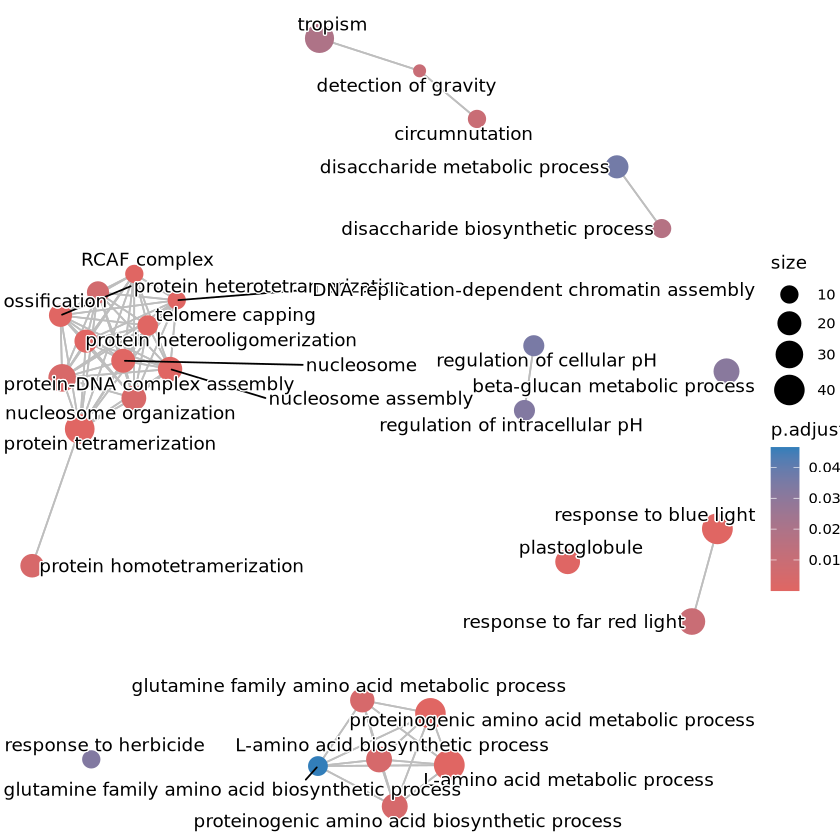

In [23]:
# 用于比较两个时期的基因富集通路占比，杨东可以尝试调试一下，搞不定就先放弃，参考链接：https://yulab-smu.top/biomedical-knowledge-mining-book/clusterprofiler-comparecluster.html

# library(clusterProfiler)
# data(gcSample)
# xx <- compareCluster(gcSample, fun="enrichKEGG",
#                      organism="hsa", pvalueCutoff=0.05)
# xx <- pairwise_termsim(xx)                     
# p1 <- emapplot(xx)
# p2 <- emapplot(xx, legend_n=2) 
# p3 <- emapplot(xx, pie="count")
# p4 <- emapplot(xx, pie="count", cex_category=1.5, layout="kk")
# cowplot::plot_grid(p1, p2, p3, p4, ncol=2, labels=LETTERS[1:4])